In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import os
sys.path.insert(1, '/idia/projects/hi_im/meerpower/meerpower')
import Init
import plot
matplotlib.rcParams['figure.figsize'] = (18, 9)

## Data read-in and pre-processing steps:

[0, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 40]


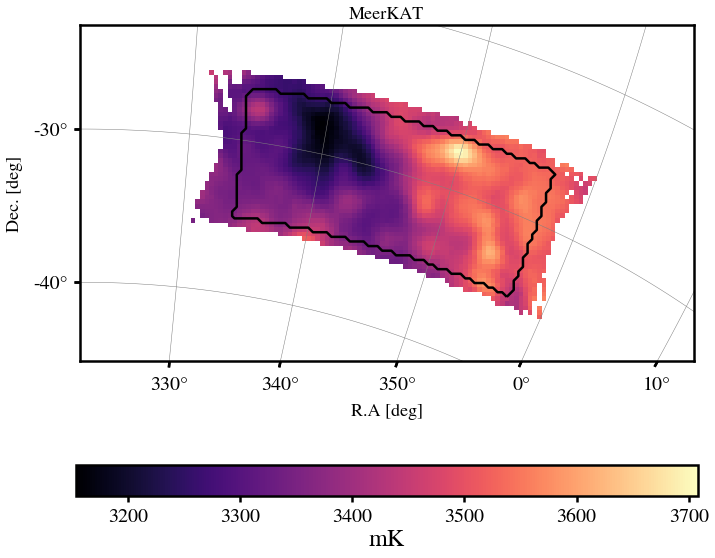

<Figure size 1296x648 with 0 Axes>

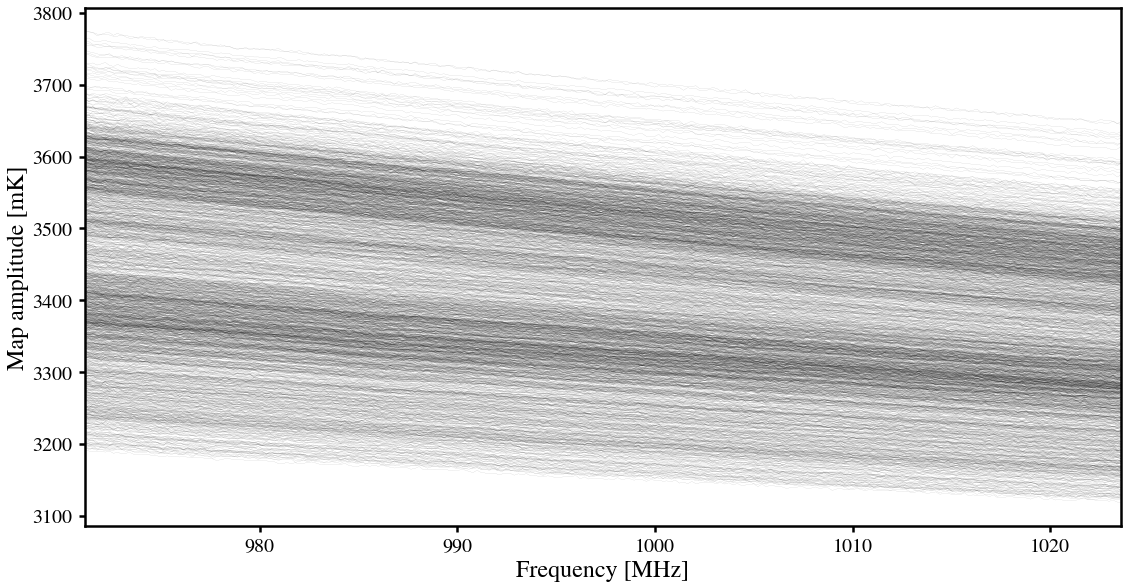

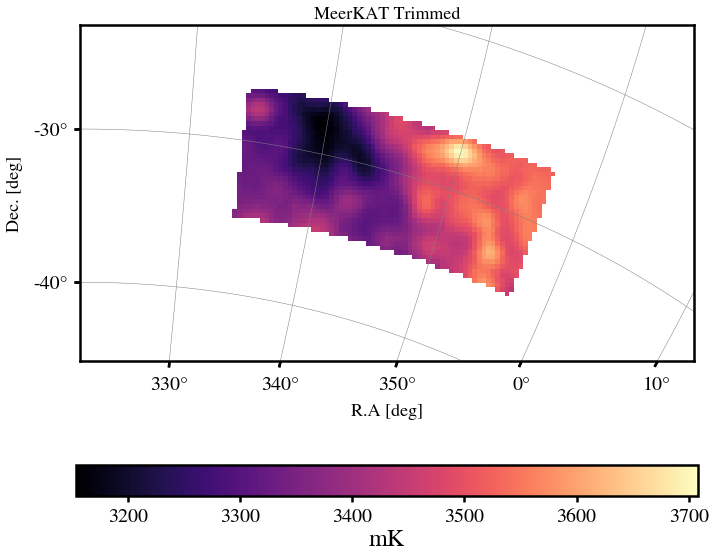

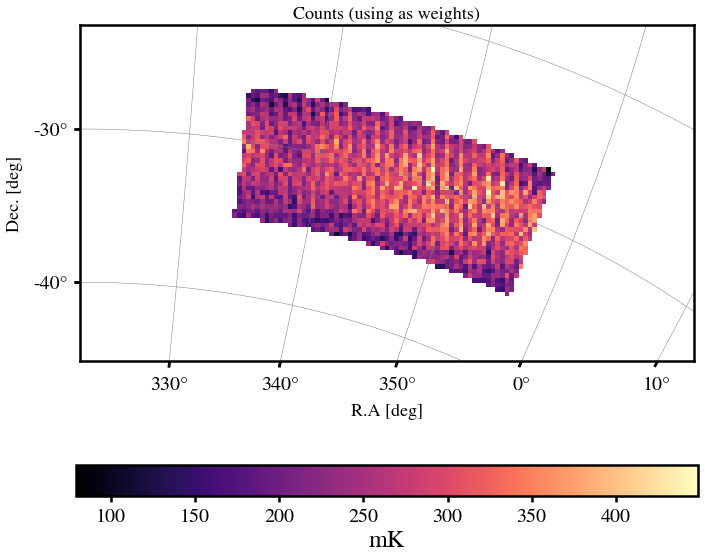

In [2]:
# Read-in level6 MeerKAT data:
#filestem = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/0.3/sigma_3/data/'
#map_file = filestem + 'Nscan966_Tsky_cube_p0.3d_sigma3.0_iter2.fits'
filestem = '/idia/users/jywang/MeerKLASS/calibration2021/level6/0.3/sigma4_count40/re_cali1_round5/'
map_file = filestem + 'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'

numin,numax = 971,1023.8 # default setting in Init.ReadIn()
MKmap,w_HI,W_HI,counts_HI,dims,ra,dec,nu,wproj = Init.ReadIn(map_file,numin=numin,numax=numax)
nx,ny,nz = np.shape(MKmap)

doMultiMapClean = True # Set True to clean all scans seperately then recombine
if doMultiMapClean==True:
    ############## CHOSE LEVEL 5 MAPS TO ANALYSE HERE: ###################
    ## - where individial dish and scan maps are stored - ################
    #level5path = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level5/0.3/data/' # previous sky model calibration technique
    level5path = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/self_cal/pix0.3_sigma4_count40/level5/re_cali1_round5/' # updated self-calibration technique
    ######################################################################
    dish_indx = np.arange(64)
    scan_indx = np.arange(41)
    scan,dish = Init.get2021IDs()
    scan_indx_valid = []
    for n in scan_indx:
        count = 0
        for m in dish_indx:
            filename = level5path + scan[n]+'_m0'+dish[m]+'_Sum_Tsky_xy_p0.3d.fits'
            if os.path.isfile(filename) is True: count+=1 # check file exists, if so, count
        if count>0: scan_indx_valid.append(n)
    print(scan_indx_valid)
    scan_indx = np.array(scan_indx_valid)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
b_g = 1.6 # tuned by eye in GAMA auto-corr
OmegaHIbHI = 0.85e-3 # MKxWiggleZ constraint
OmegaHI = OmegaHIbHI/b_HI
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))
gamma = 1.4
#gamma = None

### Remove incomplete LoS pixels from maps:
MKmap,w_HI,W_HI,counts_HI = Init.FilterIncompleteLoS(MKmap,w_HI,W_HI,counts_HI)

### Trim map edges (can fine-tune boarders if needed):
doTrim = False
if doTrim==True or doMultiMapClean==True:
    raminMK,ramaxMK = 334,357
    decminMK,decmaxMK = -35,-26.5
    ### Before trimming map, show contour of trimmed area:
    MKmap_untrim,W_HI_untrim = np.copy(MKmap),np.copy(W_HI)
    plot.Map(MKmap_untrim,W=W_HI_untrim,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT',cbarshrink=0.6)
    MKmap,w_HI,W_HI,counts_HI = Init.MapTrim(ra,dec,MKmap,w_HI,W_HI,counts_HI,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)
    contours = plt.contour(W_HI[:,:,0].T, levels=[0.5], colors='black')
    plt.show()

plot.LoSspectra(MKmap,W=W_HI,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()

### IM weights (averaging of counts along LoS so not to increase rank of the map for FG cleaning):
w_HI = np.repeat(np.mean(counts_HI,2)[:, :, np.newaxis], nz, axis=2)

plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT Trimmed',cbarshrink=0.6)
plot.Map(counts_HI,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='Counts (using as weights)',cbarshrink=0.6)
plt.show()

## Resmooth maps?:

In [3]:
if gamma is not None and doMultiMapClean==False: # not doing this for multi-map cleaning yet
    MKmap_unsmooth,w_HI_unsmooth = np.copy(MKmap),np.copy(w_HI)
    MKmap,w_HI = telescope.weighted_reconvolve(MKmap,w_HI,W_HI,ra,dec,nu,D_dish,gamma=gamma)
    plot.Map(MKmap,W=W_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT resmoothed',ZeroCentre=False)
    plot.Map(w_HI,map_ra=ra,map_dec=dec,wproj=wproj,title='MeerKAT Weight (inverse noise) resmoothed')
    plt.show()

## Foreground cleaning:

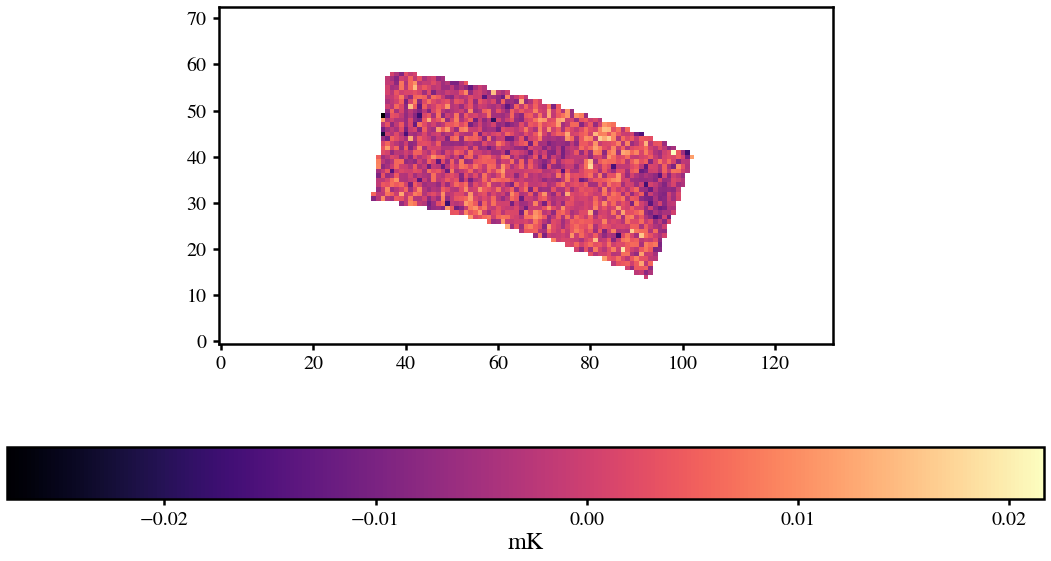

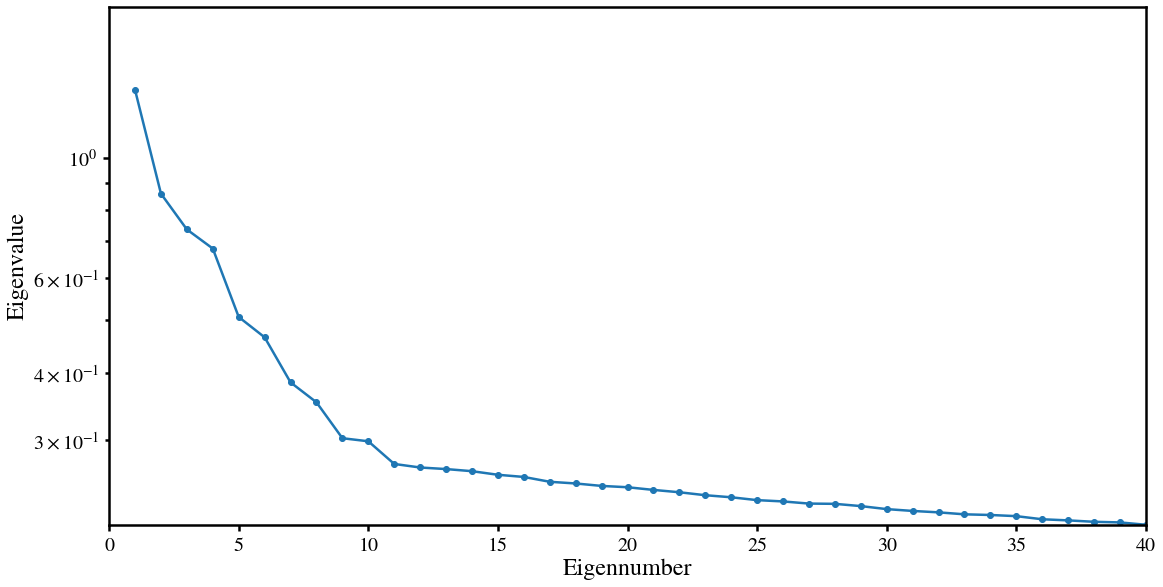

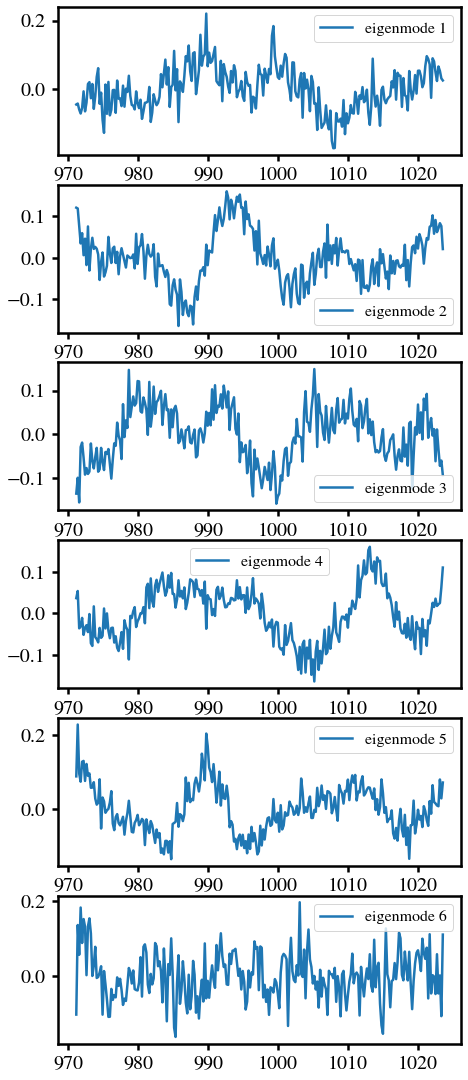

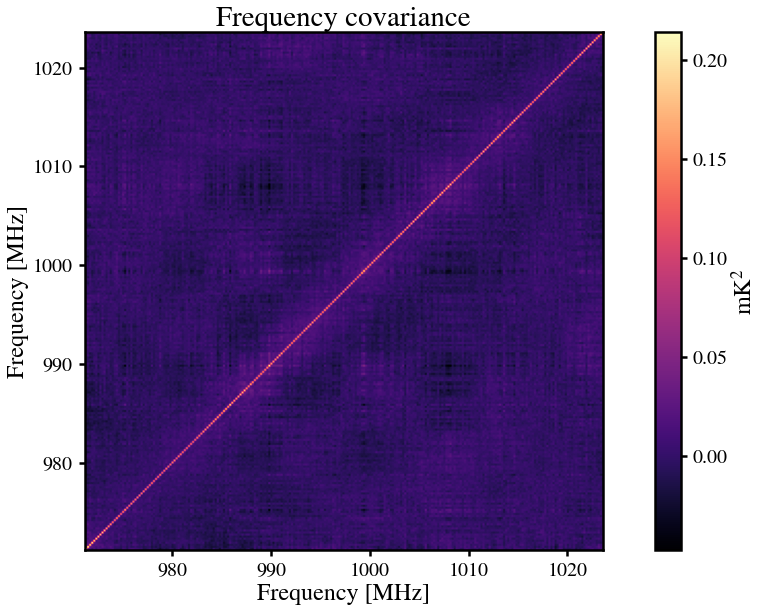

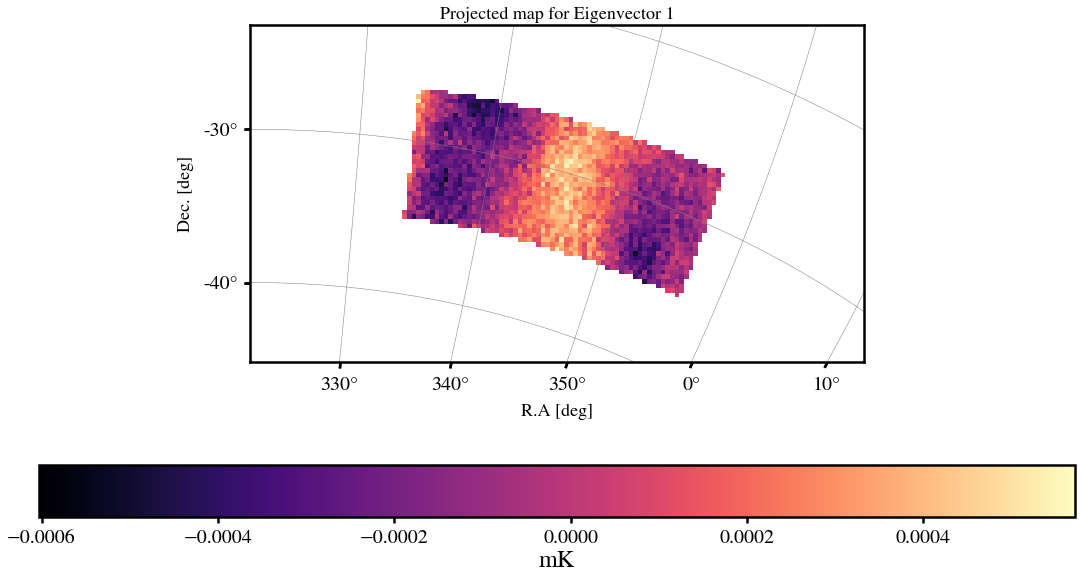

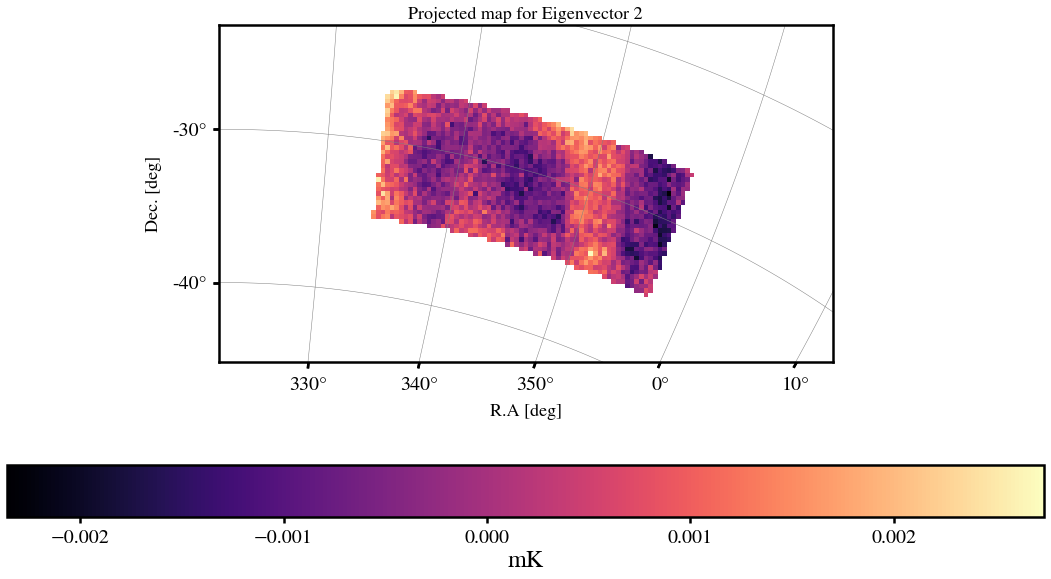

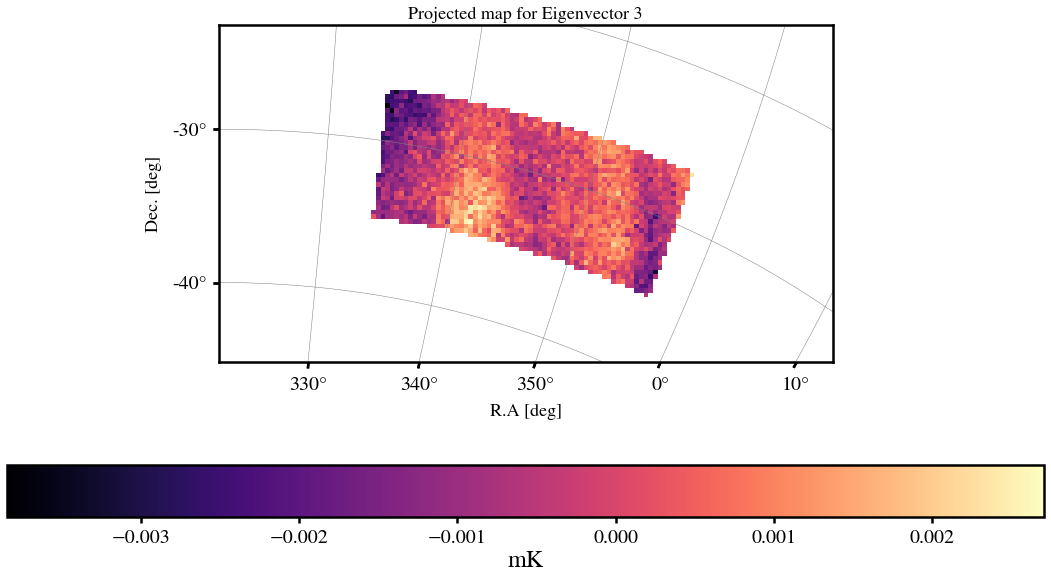

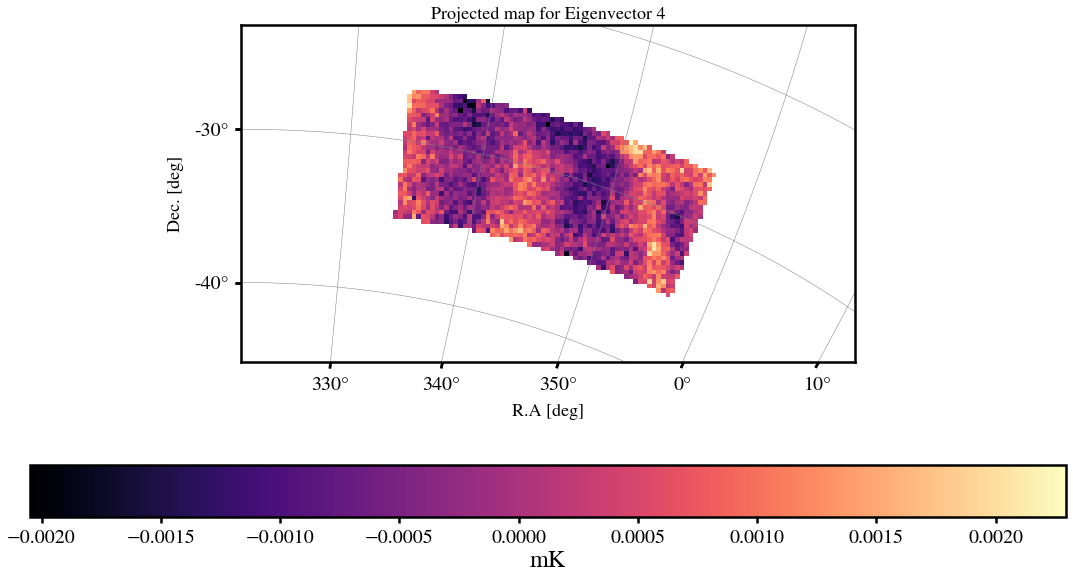

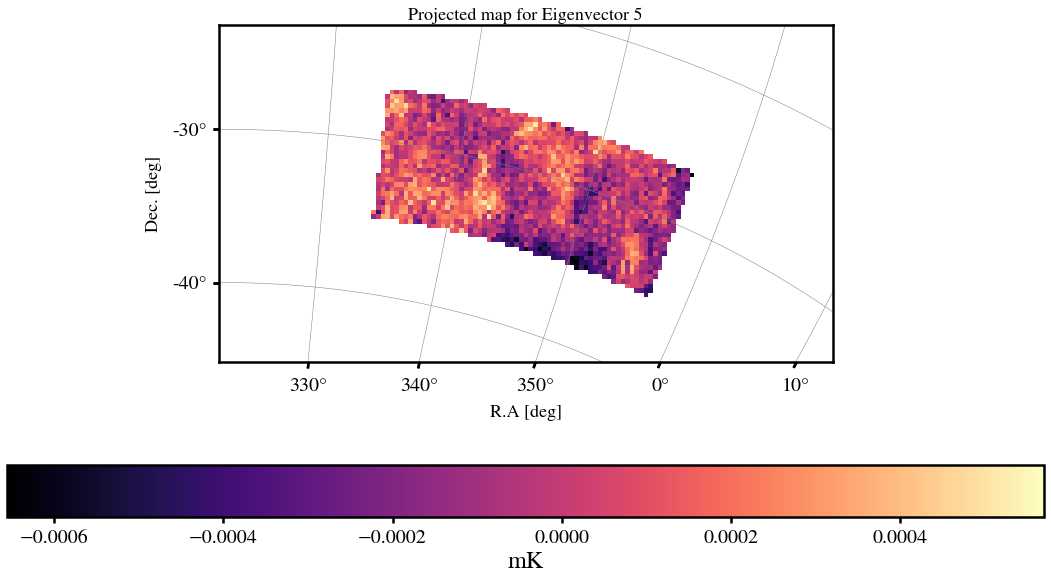

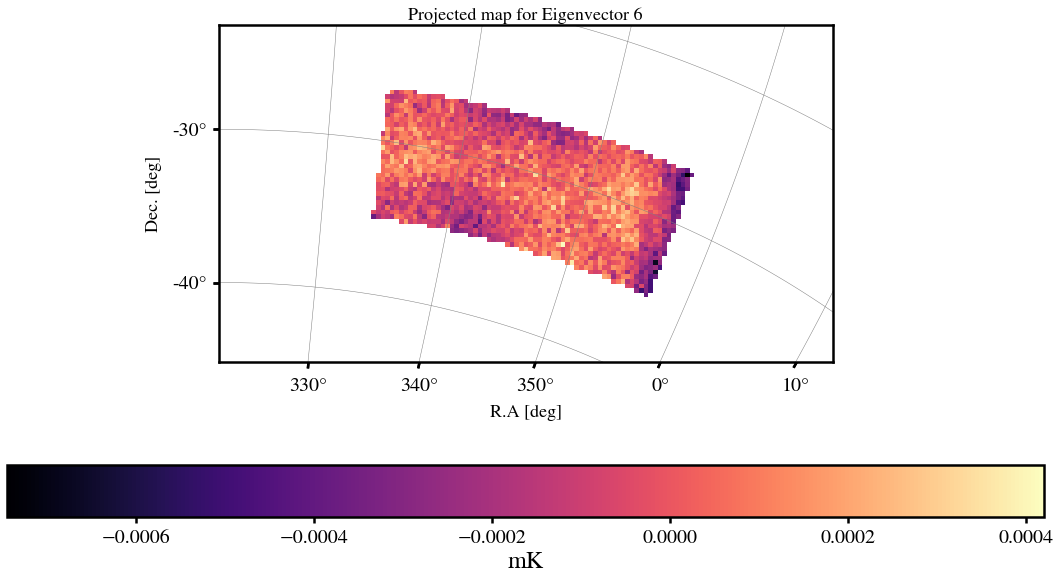

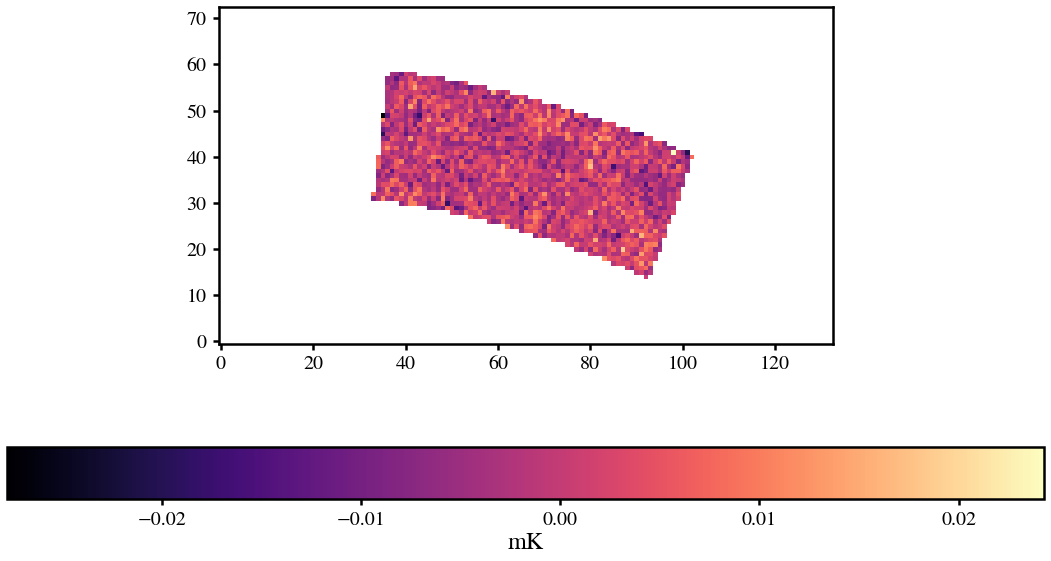

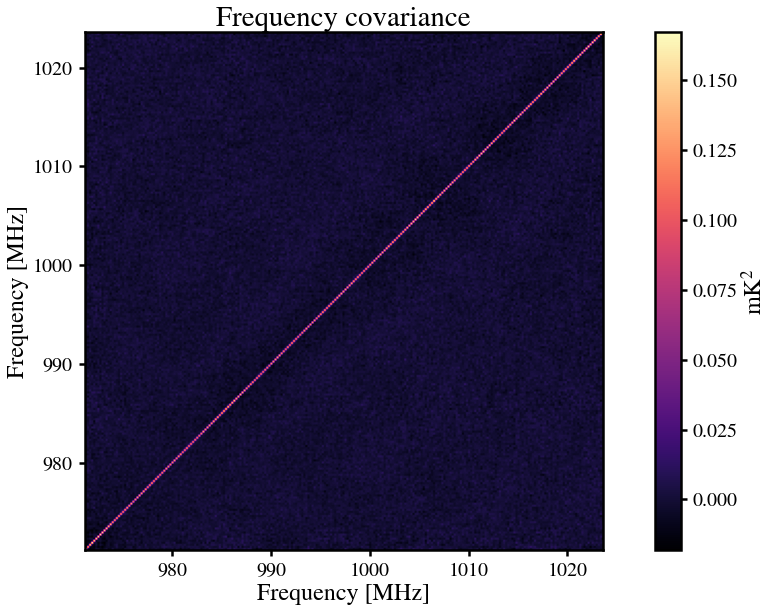

In [4]:
import foreground
if doMultiMapClean==False:
    N_fg = 10
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=w_HI)

if doMultiMapClean==True:
    eignumb_cut = 40 # highest eigenvalue to show
    for t in range(len(scan_indx)):
        if t==27:
            print(t,len(scan_indx))
            MKmap,W_HI,counts_HI = np.load('/idia/projects/hi_im/meerpower/2021Lband/multimapclean/savedmaps/dish0-63_scan%s.npy'%scan_indx[t])
            C,eignumb,eigenval,V = foreground.PCAclean(MKmap,N_fg=1,W=W_HI,w=None,returnAnalysis=True)
        
            plt.plot(eignumb,eigenval,'-o')
            
            plt.yscale('log')
            plt.ylim(bottom=eigenval[eignumb_cut])
            plt.xlim(left=0,right=eignumb_cut)
            plt.xlabel('Eigennumber')
            plt.ylabel('Eigenvalue')
            plt.show()
        
            plot.Eigenmodes(nu,V)
            plot.FrequencyCovariance(C,nu)
            plot.ProjectedEigenmodeMaps(MKmap,W_HI,V,ra,dec,wproj)
    plt.show()
    
    MKmap_weightedave = np.zeros(np.shape(MKmap))
    counts_tot = np.zeros(np.shape(MKmap))
    N_fg = 10
    for t in range(len(scan_indx)):
        if t==0 or t==16 or t==20 or t==24 or t==25 or t==26: continue
        #MKmap,W_HI,counts_HI = np.load('/idia/projects/hi_im/meerpower/2021Lband/multimapclean/savedmaps/dish0-63_scan%s.npy'%scan_indx[t])
        MKmap,W_HI,counts_HI = np.load('/idia/projects/hi_im/meerpower/2021Lband/multimapclean/savedmaps/selfcal_dish0-63_scan%s.npy'%scan_indx[t])
        MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W_HI,w=None)
        MKmap_weightedave += MKmap_clean*counts_HI
        counts_tot += counts_HI
    
    MKmap_weightedave[counts_tot!=0] /= counts_tot[counts_tot!=0]
    W_HI = np.ones(np.shape(counts_tot))
    W_HI[counts_tot==0] = 0
    plot.Map(MKmap_weightedave,W=W_HI)
    plt.show()
    
    C,eignumb,eigenval,V = foreground.PCAclean(MKmap_weightedave,N_fg=1,W=W_HI,w=None,returnAnalysis=True)
    plot.EigenSpectrum(eignumb,eigenval)
    plot.Eigenmodes(nu,V)
    plot.FrequencyCovariance(C,nu)
    plot.ProjectedEigenmodeMaps(MKmap_weightedave,W_HI,V,ra,dec,wproj)
    plt.show()
    
    #'''
    ### See what additional cleaning on recombined map does:
    N_fg = 10
    MKmap_clean = foreground.PCAclean(MKmap_weightedave,N_fg=N_fg,W=W_HI,w=None)
    plot.Map(MKmap_clean,W=W_HI)
    C,eignumb,eigenval,V = foreground.PCAclean(MKmap_clean,N_fg=1,W=W_HI,w=None,returnAnalysis=True)
    plot.FrequencyCovariance(C,nu)
    plt.show()
    #'''
    MKmap_clean = np.copy(MKmap_weightedave)

## Load overlapping spectroscopic galaxy catalogue:

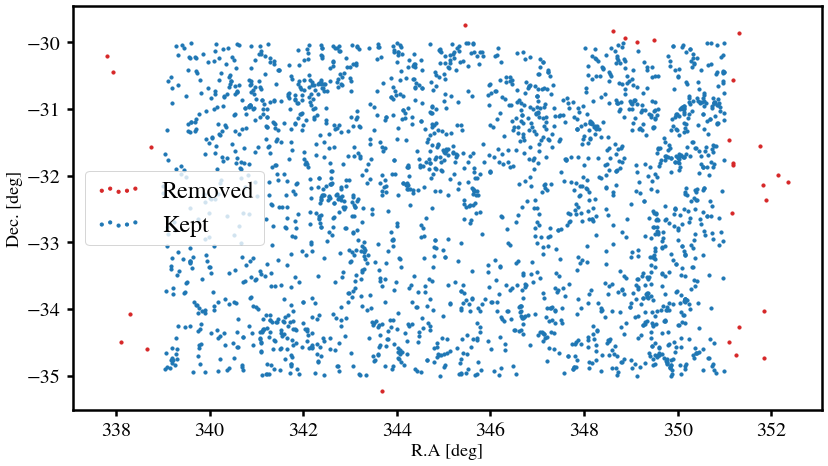

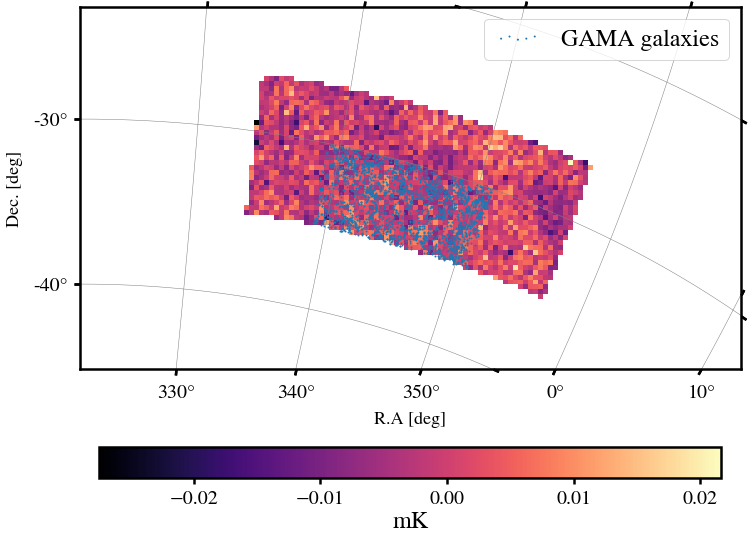

In [5]:
# Read-in GAMA galaxies:
from astropy.io import fits
Fits = '/idia/projects/hi_im/GAMA_DR4/G23TilingCatv11.fits'
hdu = fits.open(Fits)
hdr = hdu[1].header
#print(hdr)
ra_g = hdu[1].data['RA'] # Right ascension (J2000) [deg]
dec_g = hdu[1].data['DEC'] # Declination (J2000) [deg]
z_g = hdu[1].data['Z'] # Spectroscopic redshift, -1 for none attempted

### Cut redshift to MeerKAT IM range:
zmin,zmax = HItools.Freq2Red(np.max(nu)),HItools.Freq2Red(np.min(nu))
z_Lband = (z_g>zmin) & (z_g<zmax)
ra_g = ra_g[z_Lband]
dec_g = dec_g[z_Lband]
z_g = z_g[z_Lband]

### Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
raminGAMA,ramaxGAMA = 339,351
decminGAMA,decmaxGAMA = -35,-30
GAMAcutmask = (ra_g>raminGAMA) & (ra_g<ramaxGAMA) & (dec_g>decminGAMA) & (dec_g<decmaxGAMA)
plt.figure(figsize=(13,7))
plt.scatter(ra_g[~GAMAcutmask],dec_g[~GAMAcutmask],s=10,label='Removed',color='tab:red')
ra_g,dec_g,z_g = ra_g[GAMAcutmask],dec_g[GAMAcutmask],z_g[GAMAcutmask]
plt.scatter(ra_g,dec_g,s=10,label='Kept',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

### For null testing:
#np.random.shuffle(z_g)

### Plot MK map with overlaid GAMA galaxies:
plt.subplot(projection=wproj)
ax = plt.gca()
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d')
plt.grid(True, color='grey', ls='solid',lw=0.5)
img = np.mean(MKmap_clean,2)
img[W_HI[:,:,0]==0] = np.nan
plt.imshow(img.T)
cbar = plt.colorbar(orientation='horizontal',shrink=0.6)
cbar.set_label('mK')
plt.scatter(ra_g,dec_g,transform=ax.get_transform('world'),s=1,label='GAMA galaxies',color='tab:blue')
plt.xlabel('R.A [deg]',fontsize=18)
plt.ylabel('Dec. [deg]',fontsize=18)
plt.legend()
plt.show()

## Run angular stacking and spectral stacking on galaxy positions:

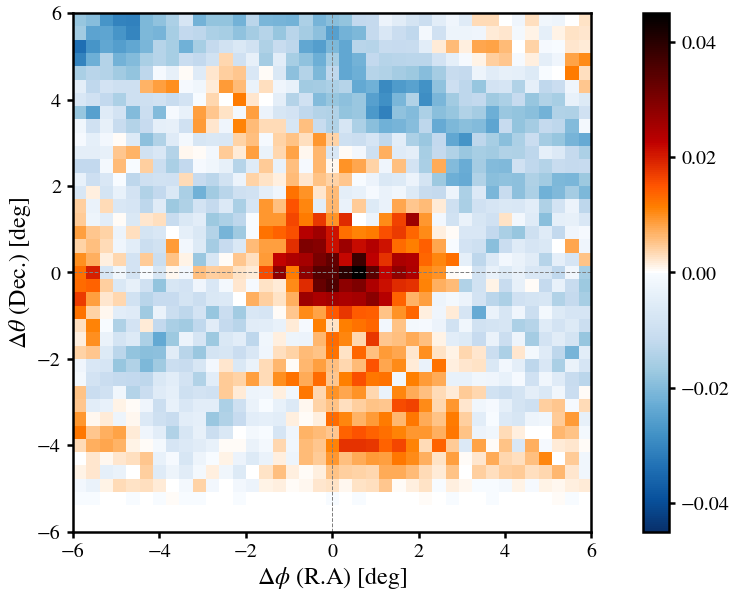

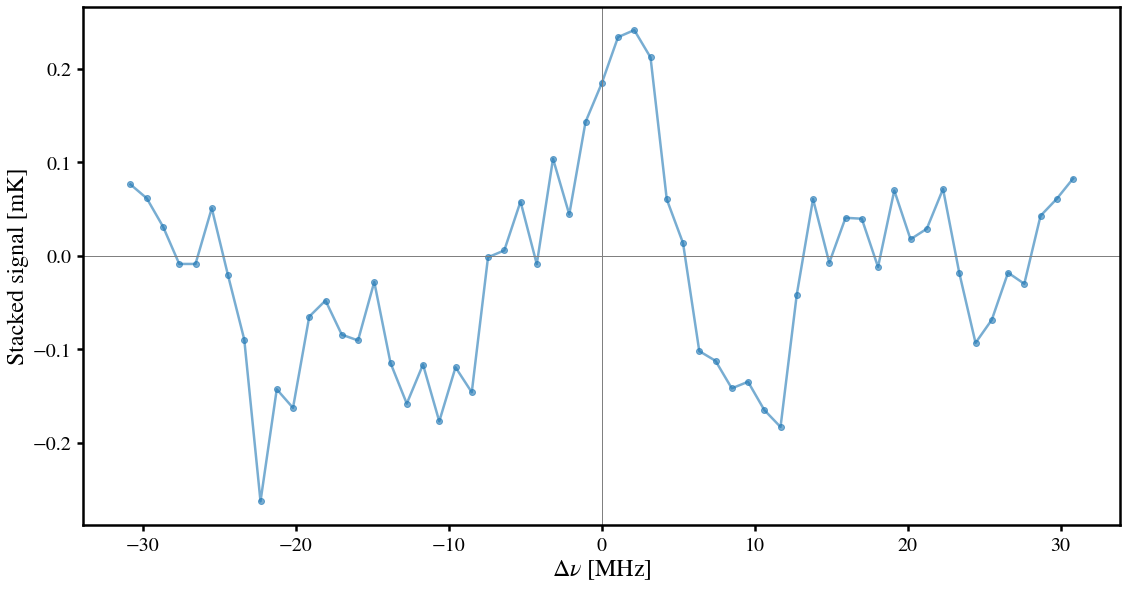

In [6]:
### Create split colorbar for 2D Pk negative values:
import matplotlib.colors as mcolors
colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

ra_cont,ra_g_cont = np.copy(ra),np.copy(ra_g)
ra_cont[ra>180] = ra[ra>180] - 360
ra_g_cont[ra_g>180] = ra_g[ra_g>180] - 360

import stack
degmax = 6 # max/min of stacked map [deg]
ddegpix = 0.3 # width of stacked pixels [deg]
ddeg,counts = stack.angular(MKmap_clean,W_HI,ra_g_cont,dec_g,z_g,ra_cont,dec,nu,degmax,ddegpix,dnu=5,w=None)
np.save('/idia/projects/hi_im/meerpower/2021Lband/gama/data/stackang_result_Nfg=%s'%N_fg,[ddeg,counts])

plt.imshow(ddeg,extent=[-degmax,degmax,-degmax,degmax],vmin=-np.max(ddeg),vmax=np.max(ddeg),cmap=mycmap)
plt.axhline(0,color='gray',ls='--',lw=1)
plt.axvline(0,color='gray',ls='--',lw=1)
plt.xlabel(r'$\Delta\phi$ (R.A) [deg]')
plt.ylabel(r'$\Delta\theta$ (Dec.) [deg]')
plt.colorbar()
#plt.title(r'$N_{\rm fg}=$%s'%N_fg)
plt.show()

nnu_stack = 150 # +/- nnu_stack channels either side of centred galaxy redshift
nnu_bins = 60 # number of bins
d,nustack_bins = stack.spectral(MKmap_clean,W_HI,ra_g,dec_g,z_g,ra,dec,nu,nnu_stack,nnu_bins)
plt.plot(nustack_bins,d,'-o',alpha=0.6)
plt.axhline(0,lw=1,color='gray')
plt.axvline(0,lw=1,color='gray')
plt.xlabel(r'$\Delta\nu$ [MHz]')
plt.ylabel('Stacked signal [mK]')
plt.show()


### Repeat pipeline on mocks:
Mocks are lognormals with counterpart galaxy catalogue approximately resembling GAMA galaxy number density. For HI, add real MeerKAT maps to the mocks and foreground clean to emulate foreground and systematic contamination/signal loss

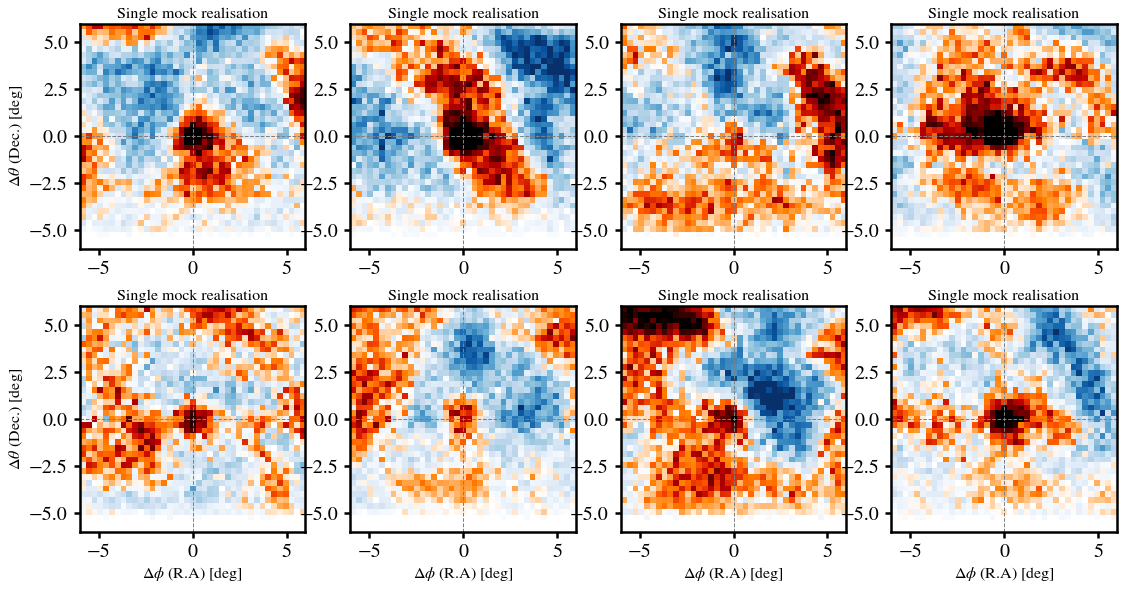

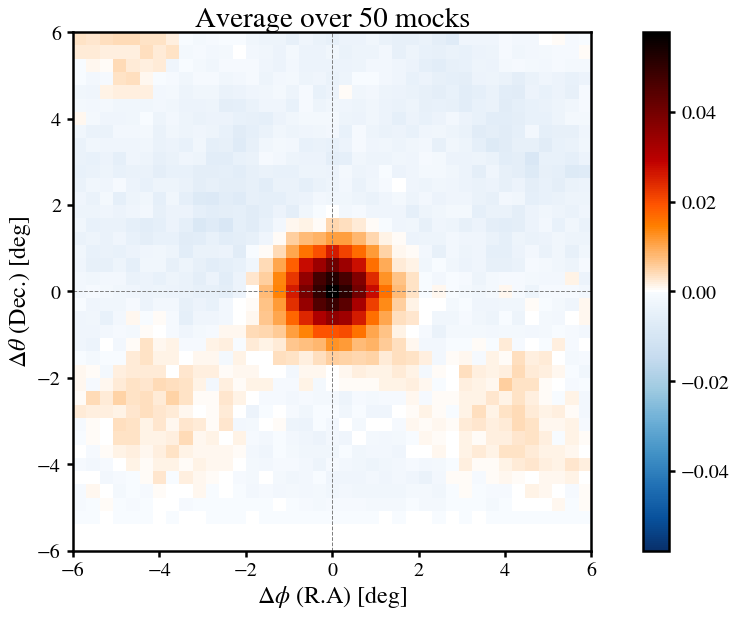

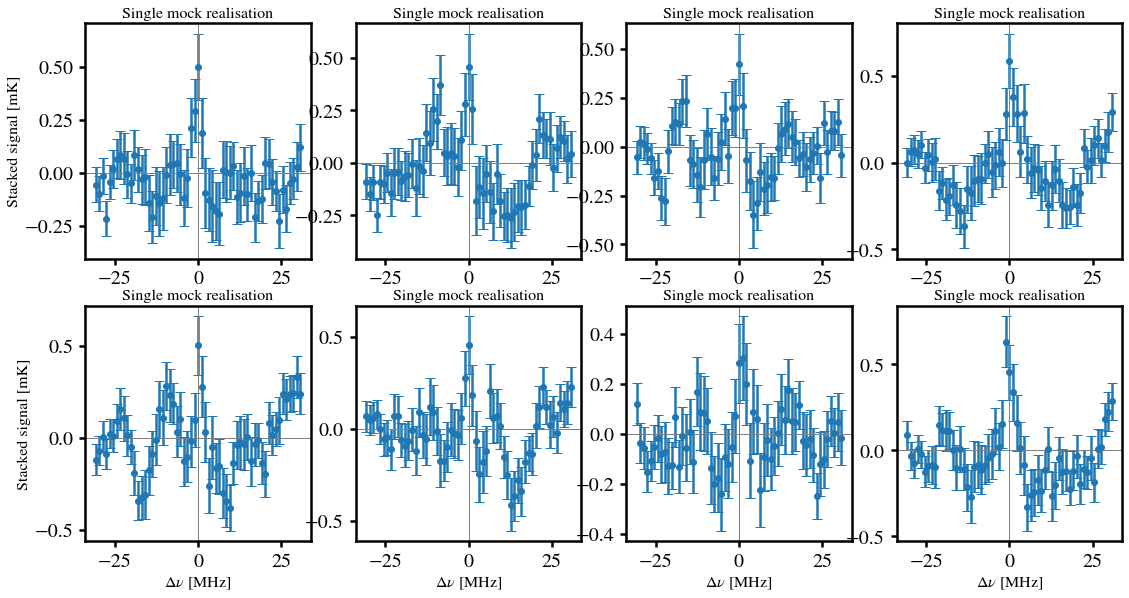

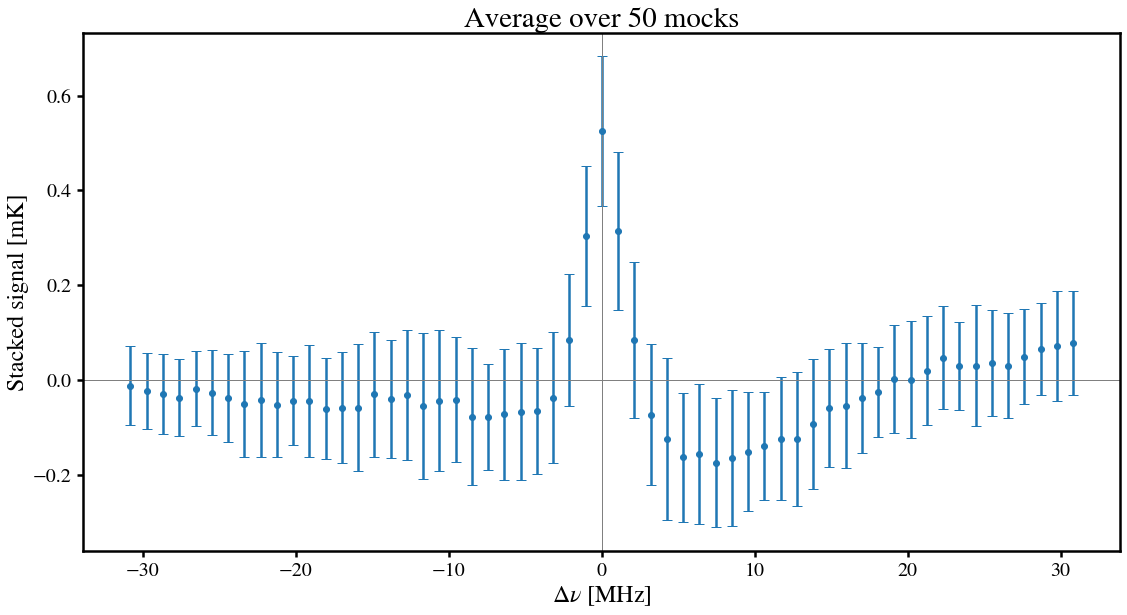

In [9]:
'''
# Comment out once run to avoid computing everytime
Nmock = 50
ddeg_i = np.zeros((Nmock,np.shape(ddeg)[0],np.shape(ddeg)[1]))
d_i = np.zeros((Nmock,len(d)))
mockindx = np.arange(500)
np.random.shuffle(mockindx)
for i in range(Nmock):
    plot.ProgressBar(i,Nmock)
    mockmap = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam_%s.npy'%mockindx[i])
    ra_g_mock,dec_g_mock,z_g_mock = np.load('/idia/projects/hi_im/meerpower/2021Lband/mocks/mockGAMAcat_%s.npy'%mockindx[i])
    ra_g_mock_cont = np.copy(ra_g_mock)
    ra_g_mock_cont[ra_g_mock_cont>180] = ra_g_mock_cont[ra_g_mock_cont>180] - 360

    if doMultiMapClean==False:
        mockmap += MKmap_unsmooth # add real MK data to emulate foregrounds/systematics
        if gamma is not None: mockmap,null = telescope.weighted_reconvolve(mockmap,w_HI_unsmooth,W_HI,ra,dec,nu,D_dish,gamma=gamma)
        mockmap[W_HI==0] = 0 # apply same trim and flags 
        mockmap_clean = foreground.PCAclean(mockmap,N_fg=N_fg,W=W_HI,w=w_HI)

    if doMultiMapClean==True:
        mockmap_weightedave = np.zeros(np.shape(mockmap))
        counts_tot = np.zeros(np.shape(mockmap))
        N_fg = 10
        for t in range(len(scan_indx)):
            if t==0 or t==16 or t==20 or t==24 or t==25 or t==26: continue
            #MKmap,W_HI,counts_HI = np.load('/idia/projects/hi_im/meerpower/2021Lband/multimapclean/savedmaps/dish0-63_scan%s.npy'%scan_indx[t])
            MKmap,W_HI,counts_HI = np.load('/idia/projects/hi_im/meerpower/2021Lband/multimapclean/savedmaps/selfcal_dish0-63_scan%s.npy'%scan_indx[t])
            
            mockmap_wFG = MKmap + mockmap # add real MK data to emulate foregrounds/systematics
            mockmap_wFG[W_HI==0] = 0 # apply same trim and flags 
            mockmap_clean = foreground.PCAclean(mockmap_wFG,N_fg=N_fg,W=W_HI,w=None)
            mockmap_weightedave += mockmap_clean*counts_HI
            counts_tot += counts_HI
        
        mockmap_weightedave[counts_tot!=0] /= counts_tot[counts_tot!=0]
        W_HI = np.ones(np.shape(counts_tot))
        W_HI[counts_tot==0] = 0
        mockmap_clean = np.copy(mockmap_weightedave)

    ddeg_i[i],counts = stack.angular(mockmap_clean,W_HI,ra_g_mock_cont,dec_g_mock,z_g_mock,ra_cont,dec,nu,degmax,ddegpix,dnu=5,w=None)
    d_i[i],nustack_bins = stack.spectral(mockmap_clean,W_HI,ra_g_mock,dec_g_mock,z_g_mock,ra,dec,nu,nnu_stack,nnu_bins)
'''

nexample = 8
fig, axs = plt.subplots(2,int(nexample/2))
mockindx = np.arange(np.shape(ddeg_i)[0])
np.random.shuffle(mockindx)
for i in range(nexample):
    if i<4:
        xi = 0
        yi = i
    else: 
        xi = 1
        yi = i - 4
    axs[xi,yi].imshow(ddeg_i[mockindx[i]],extent=[-degmax,degmax,-degmax,degmax],vmin=-np.max(np.mean(ddeg_i,0)),vmax=np.max(np.mean(ddeg_i,0)),cmap=mycmap)
    axs[xi,yi].axhline(0,color='gray',ls='--',lw=1)
    axs[xi,yi].axvline(0,color='gray',ls='--',lw=1)
    if i>3: axs[xi,yi].set_xlabel(r'$\Delta\phi$ (R.A) [deg]',fontsize=16)
    if i==0 or i==4: axs[xi,yi].set_ylabel(r'$\Delta\theta$ (Dec.) [deg]',fontsize=16)
    axs[xi,yi].set_title('Single mock realisation',fontsize=16)
plt.show()
plt.imshow(np.mean(ddeg_i,0),extent=[-degmax,degmax,-degmax,degmax],vmin=-np.max(np.mean(ddeg_i,0)),vmax=np.max(np.mean(ddeg_i,0)),cmap=mycmap)
plt.axhline(0,color='gray',ls='--',lw=1)
plt.axvline(0,color='gray',ls='--',lw=1)
plt.xlabel(r'$\Delta\phi$ (R.A) [deg]')
plt.ylabel(r'$\Delta\theta$ (Dec.) [deg]')
plt.colorbar()
plt.title('Average over %s mocks'%np.shape(ddeg_i)[0])
plt.show()


nexample = 8
fig, axs = plt.subplots(2,int(nexample/2))
mockindx = np.arange(np.shape(ddeg_i)[0])
np.random.shuffle(mockindx)
for i in range(nexample):
    if i<4:
        xi = 0
        yi = i
    else: 
        xi = 1
        yi = i - 4
    axs[xi,yi].errorbar(nustack_bins,d_i[mockindx[i]],np.std(d_i,0),marker='o',ls='none')
    axs[xi,yi].axhline(0,lw=1,color='gray')
    axs[xi,yi].axvline(0,lw=1,color='gray')
    if i>3: axs[xi,yi].set_xlabel(r'$\Delta\nu$ [MHz]',fontsize=16)
    if i==0 or i==4: axs[xi,yi].set_ylabel('Stacked signal [mK]',fontsize=16)
    axs[xi,yi].set_title('Single mock realisation',fontsize=16)
plt.show()

plt.errorbar(nustack_bins,np.mean(d_i,0),np.std(d_i,0),marker='o',ls='none')
plt.axhline(0,lw=1,color='gray')
plt.axvline(0,lw=1,color='gray')
plt.xlabel(r'$\Delta\nu$ [MHz]')
plt.ylabel('Stacked signal [mK]')
plt.title('Average over %s mocks'%np.shape(ddeg_i)[0])
plt.show()

### Include errors from mock realisations in final data estimate:
And estimate statistical significance of detection


Detection Significance: 8.105 sigma


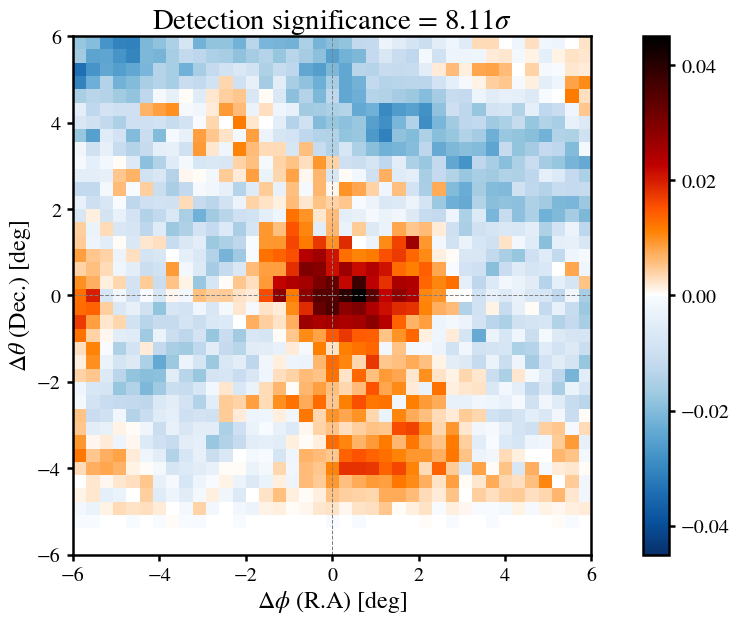


Detection Significance: 2.097 sigma


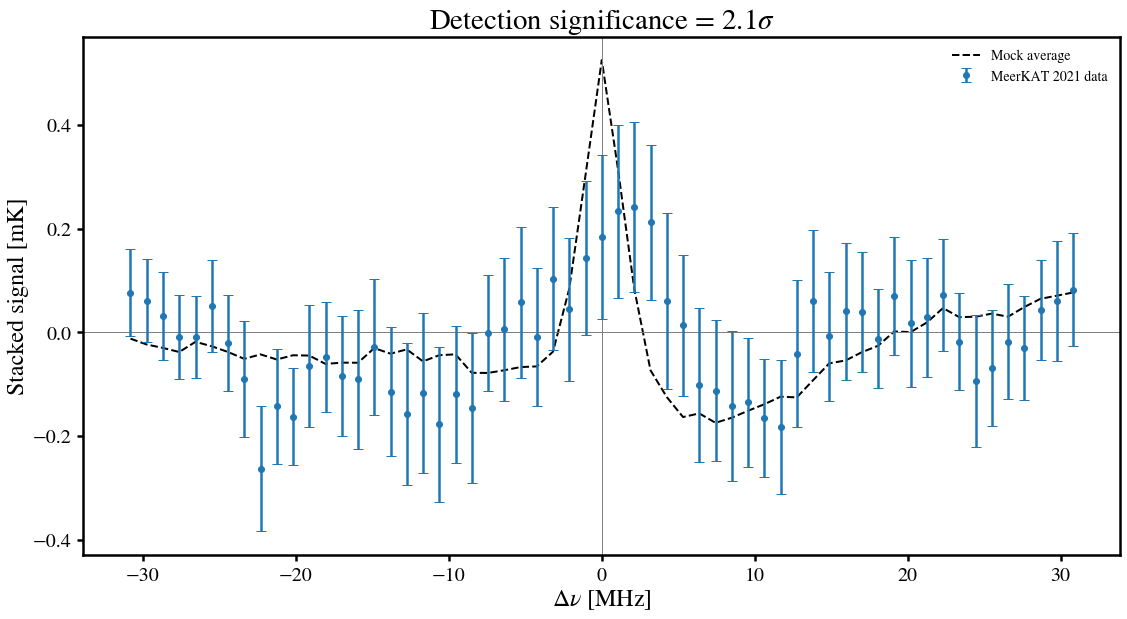

In [10]:
import model
mod = np.mean(ddeg_i,0)
errors = np.std(ddeg_i,0)
det_sig = model.DetectionSigma(ddeg[errors!=0],mod[errors!=0],errors[errors!=0])
plt.imshow(ddeg,extent=[-degmax,degmax,-degmax,degmax],vmin=-np.max(ddeg),vmax=np.max(ddeg),cmap=mycmap)
plt.axhline(0,color='gray',ls='--',lw=1)
plt.axvline(0,color='gray',ls='--',lw=1)
plt.xlabel(r'$\Delta\phi$ (R.A) [deg]')
plt.ylabel(r'$\Delta\theta$ (Dec.) [deg]')
plt.colorbar()
plt.title(r'Detection significance = %s$\sigma$'%np.round(det_sig,2))
plt.show()

#numask = (nustack_bins>-20) & (nustack_bins<20)
numask = (nustack_bins>-10000) & (nustack_bins<10000)
mod = np.mean(d_i,0)
errors = np.std(d_i,0)
det_sig = model.DetectionSigma(d[numask],mod[numask],errors[numask])
plt.plot(nustack_bins,mod,color='black',ls='--',lw=2,label='Mock average')
plt.errorbar(nustack_bins,d,np.std(d_i,0),marker='o',ls='none',label='MeerKAT 2021 data',zorder=10)
plt.axhline(0,lw=1,color='gray')
plt.axvline(0,lw=1,color='gray')
plt.xlabel(r'$\Delta\nu$ [MHz]')
plt.ylabel('Stacked signal [mK]')
plt.legend(fontsize=14,frameon=False)
plt.title(r'Detection significance = %s$\sigma$'%np.round(det_sig,2))
plt.show()
